In [686]:
import sys
sys.path.append("./analysis.py")
from analysis import actions, getHistory, date_day, date_time, findBillNum, Action, Bill, collectConnections, getReferencedBills
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib as mpl

In [438]:
from collections import namedtuple


def getTimestamp(date):
  return parse(date).timestamp()

Time_Connect = namedtuple('Time_Connect', ['source', 'target', 'timestamp'])

def getAllConnectionTimes(actions):
  connections = []
  for i in actions:
    target = findBillNum.search(i.action)
    if target is not None: 
      connections.append((Time_Connect(i.id, target.group, getTimestamp(i.date))))
  return connections


In [ ]:


bill_points = {}


def getConnectionTree(bill):
  connections = []
  baggage=[]
  hist = getHistory(bill)
  for h in hist: 
    targets = findBillNum.findall(h.action)
    for target in targets: 
      if target and target not in baggage: 
        connections.append({'source': bill, 'target': target, 'timestamp': parse(h.date).timestamp()})
        baggage.append(target)
  if connections is not None: 
    return [connections, baggage]




for a in list(set(actions))[:50]:
  if a.id not in bill_points: 
    bill_points[a.id] = []
    c, b = getConnectionTree(a.id)
    if c is not None:
      for c in c:
        if c is not None: 
          bill_points[a.id].append(c)
          
display(bill_points)

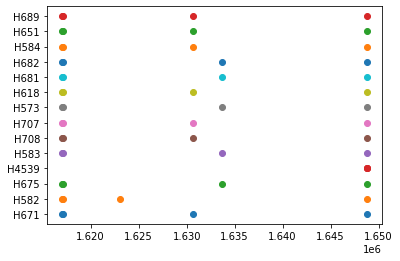

In [646]:


SAT= namedtuple('SAT', ['action', 'time'])


def SATactions(id):
  hist = getHistory(id)
  SATs = [SAT(h.action, int(parse(h.date).timestamp()/1000)) for h in hist]
  return (id, SATs)
   
   
def make_history_dict(bills):
  history = []
  visited = []
  for a in bills: 
    if a in visited: 
      continue
    history.append(SATactions(a))
    visited.append(a)
  return history




def getConnectionTree(actions):
  for a in actions: 
    bill_cloud = collectConnections(a.id)
    if 20 > len(bill_cloud) > 10: 
      hd = make_history_dict(bill_cloud)
      return hd


tree = getConnectionTree(actions[12500:15000])

if tree: 
  for i in tree: 
    plt.scatter([t.time for t in i[1]], [i[0] for t in i[1]])
  plt.show()




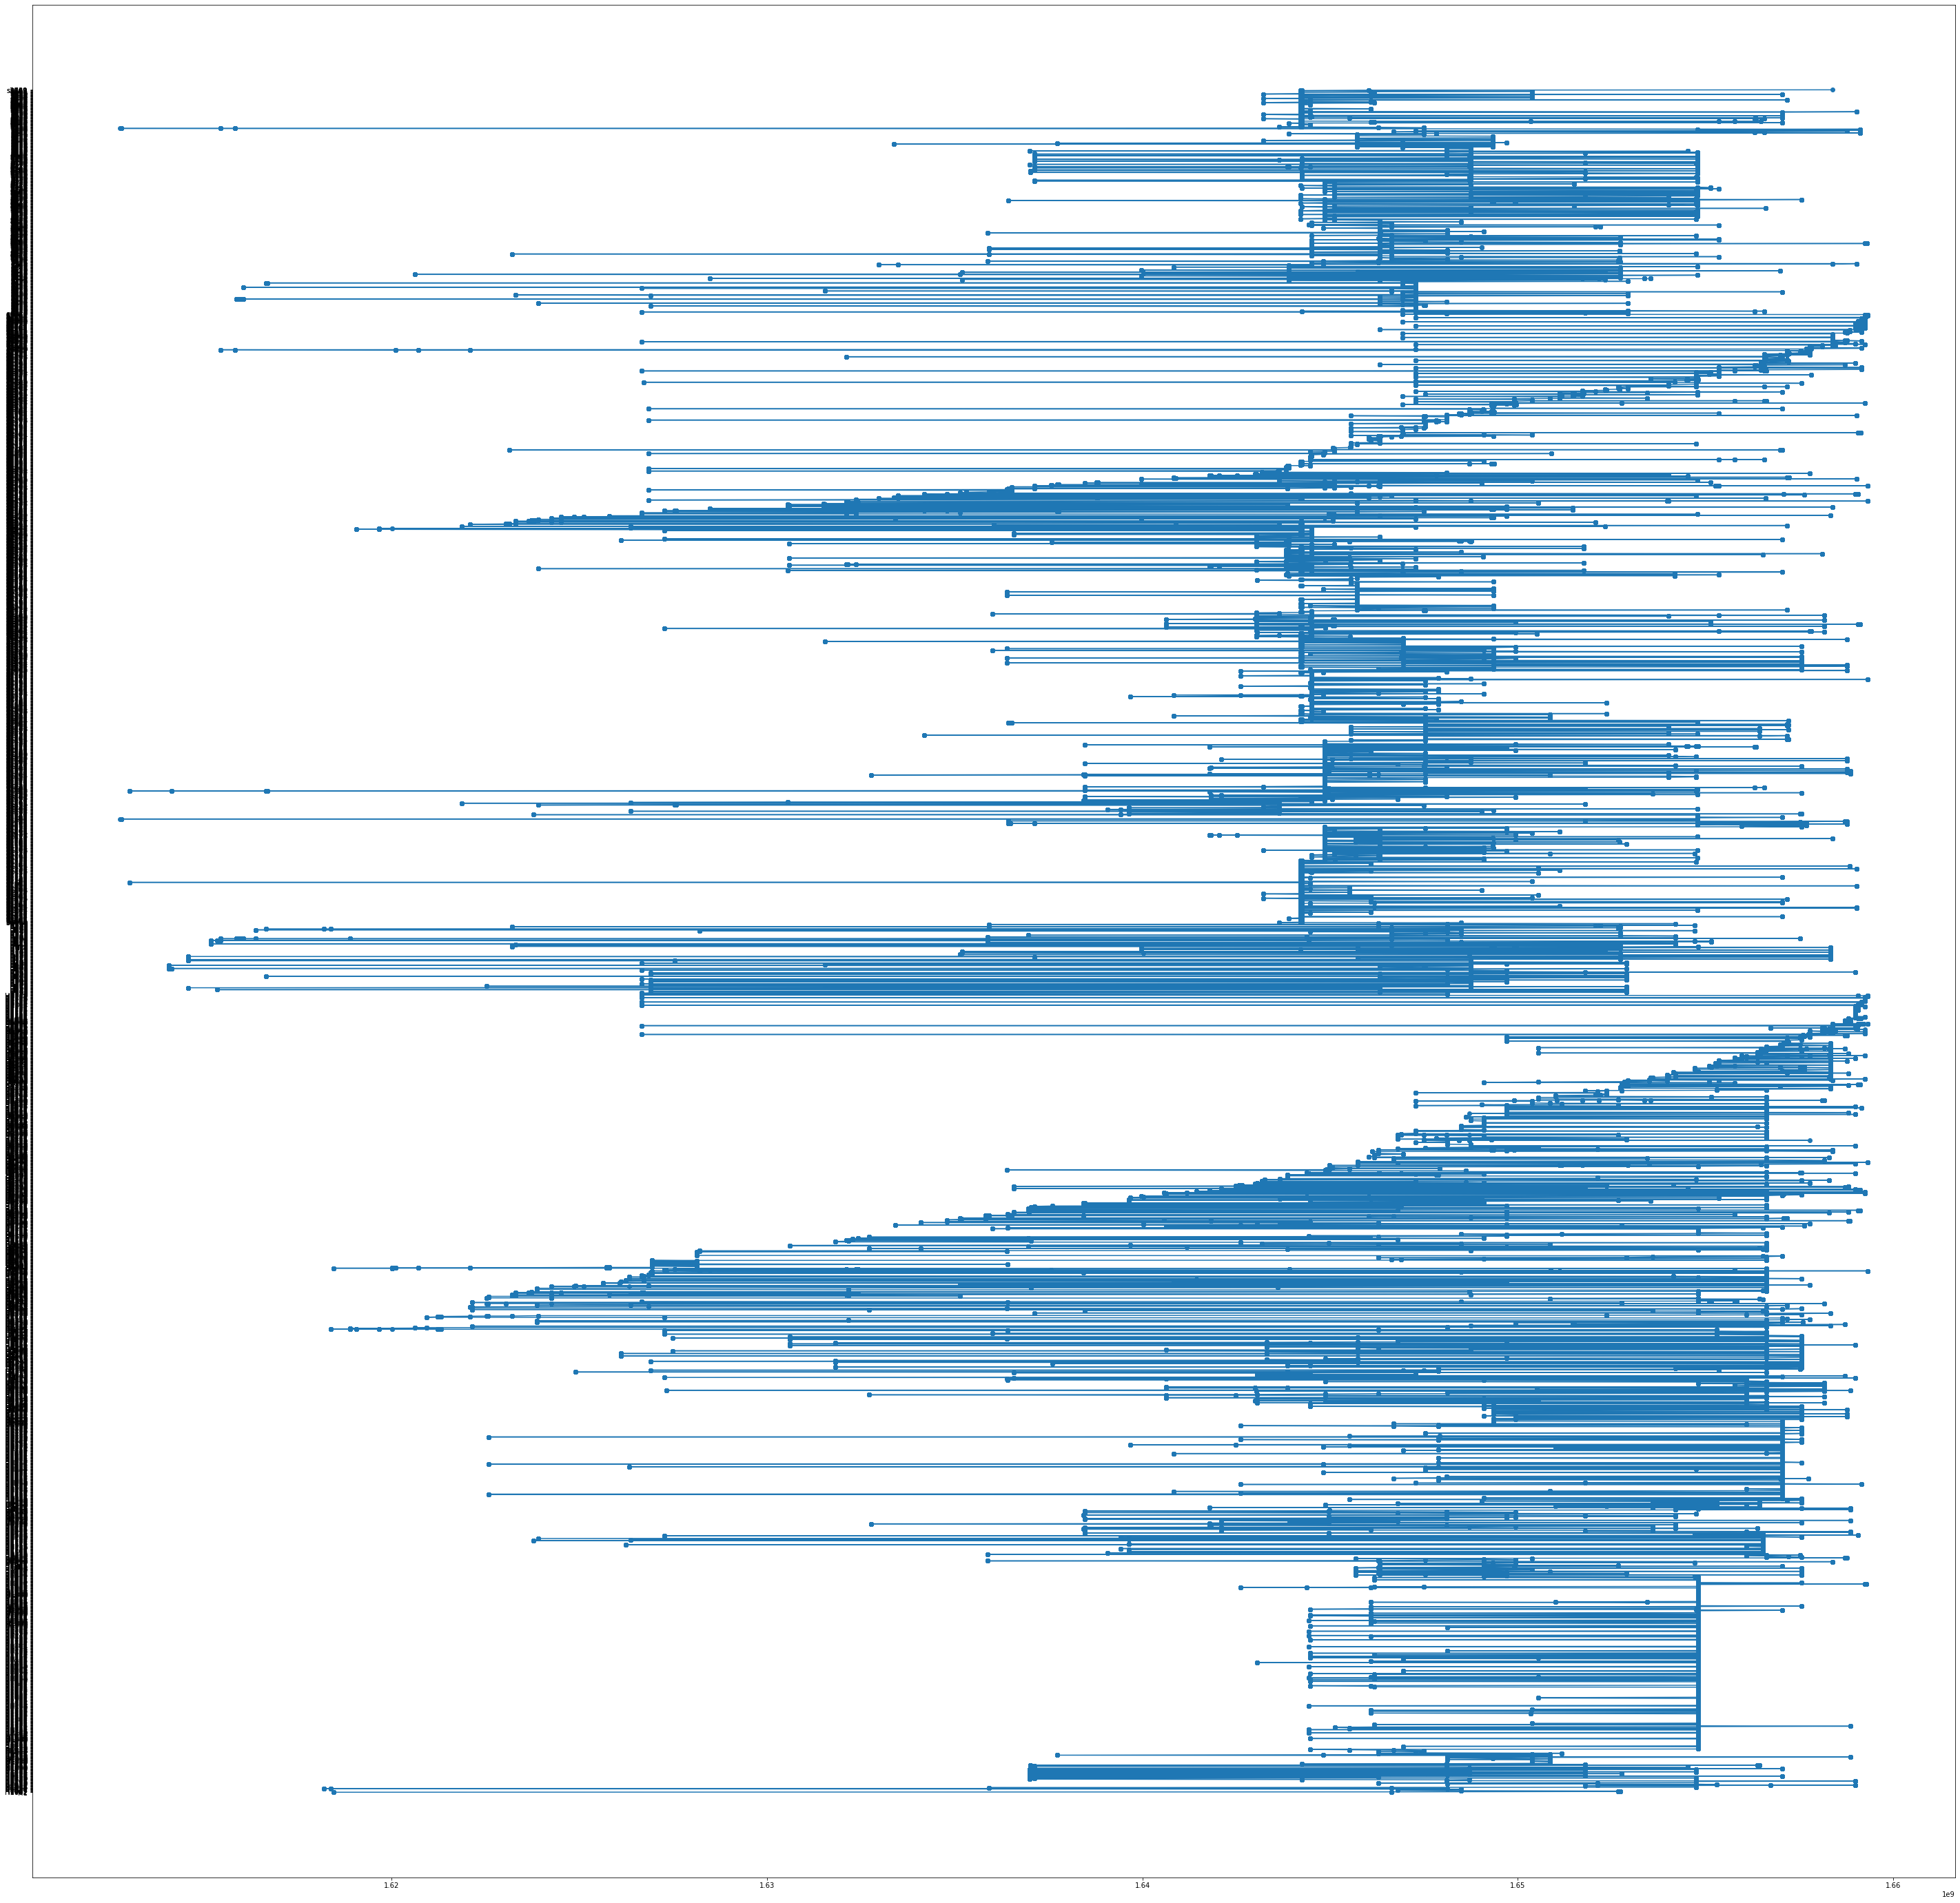

In [513]:

def getEdges(bill):
  timed_edges = []
  
  hist = getHistory(bill)
  for h in hist: 
    targets = findBillNum.findall(h.action)
    for target in targets: 
      if target:
        timed_edges.extend([[parse(h.date).timestamp(), bill], [parse(h.date).timestamp(), target]])
  if timed_edges is not None: 
    return timed_edges


def getEdgeArrays(actions):
  raw_edge = []
  for a in actions:
    raw_edge.extend(getEdges(a.id))
  return raw_edge
    

  
  
edge_array = sorted(getEdgeArrays(actions), key=lambda x : x[1])

plt.figure(figsize=(50, 50))

plt.plot([x[0] for x in edge_array], [y[1] for y in edge_array])
plt.scatter([x[0] for x in edge_array], [y[1] for y in edge_array])





In [ ]:
FAL = namedtuple('FAL', ['source', 't1', 't2'])




first_and_lasts = []
visited = []
first = None
last = None

for a in actions[:20000]: 
  if a.id not in visited: 
    if first is not None: 
      first_and_lasts.append(FAL(first.id, parse(first.date).timestamp(), parse(last.date).timestamp()))
    first = a
    visited.append(a.id)
  else: 
    last = a




fig, ax = plt.subplots()

fig.set_size_inches(15, 100)


# for x in sorted(first_and_lasts, key=lambda x: x[1]):
cutoff = parse("Jan 1, 2022").timestamp()
for x in first_and_lasts:
  if x[2] > cutoff: 
    plt.plot([x[1], x[2]], [x[0], x[0]])




In [808]:
flat_children = dict()


def getChildren(bill):
  if bill in flat_children:
    return flat_children[bill]['children']
  if bill not in flat_children: 
    hist = getHistory(bill)
    refs = list(getReferencedBills(hist))
    flat_children[bill] = {'id': bill, 'children': {}}
    
    for r in refs: 
      if r in bill:
        flat_children[bill][r] = flat_children[r]
      elif r not in flat_children[bill]:
        flat_children[bill]['children'] = {r: getChildren(r)}

  return flat_children[bill] 
  # flat_children[bill] = {'children': children}
  # for r in refs:
  #   if r is not None and r not in flat_children[bill]:
  #     children = getChildren(r)
  #     flat_children[bill][r] = children
  # return flat_children[bill]
  


bills = list(set(actions))

for x in actions[:100]:
  getChildren(x.id)


import json

dump = json.dumps(flat_children)

print(dump)





ValueError: Circular reference detected